# Homework 10 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [2]:
%matplotlib inline
import os
import shapely
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pylab as pl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from geopandas import GeoDataFrame

In [3]:
def curlfile(url, outfile):
    """Downloads file from url to PUIdata, returns output file path.
    Arguments:
    url - url location of descired file (string).
    outfile - name of downloaded file (string).
    """
    outfile = os.getenv('PUIDATA') + '/' + outfile
    os.system('curl -o ' + outfile + ' ' + url)
    return outfile

# Curl data from github to PUIDATA
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' + 
         'master/Lab9_SRK325/Data/ACS_CT2010.csv', 'ACS_CT2010.csv')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
         'master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv',
         'CitiBike_monthly_byStation.csv')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
         'master/Lab9_SRK325/Data/Station_id.csv','Station_id.csv')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
         'master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv',
         'R10_BoroCT2010.csv')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/' +
         'Lab9_SRK325/Data/CT_Shape/ct_shape.cpg', 'ct_shape.cpg')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/' +
         'Lab9_SRK325/Data/CT_Shape/ct_shape.dbf', 'ct_shape.dbf')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/' +
         'Lab9_SRK325/Data/CT_Shape/ct_shape.prj', 'ct_shape.prj')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/' +
         'Lab9_SRK325/Data/CT_Shape/ct_shape.shp', 'ct_shape.shp')
curlfile('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/' +
         'Lab9_SRK325/Data/CT_Shape/ct_shape.shx', 'ct_shape.shx')

'/Users/JordanVani/Documents/NYU/PUI/PUIdata//ct_shape.shx'

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:
shape_path = os.getenv('PUIDATA') + "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
ct_data.index = ct_data.BoroCT2010.astype(str)

## Explore CitiBike data

### Load CitiBike data

In [6]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')

### Time Series Aanalysis

/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


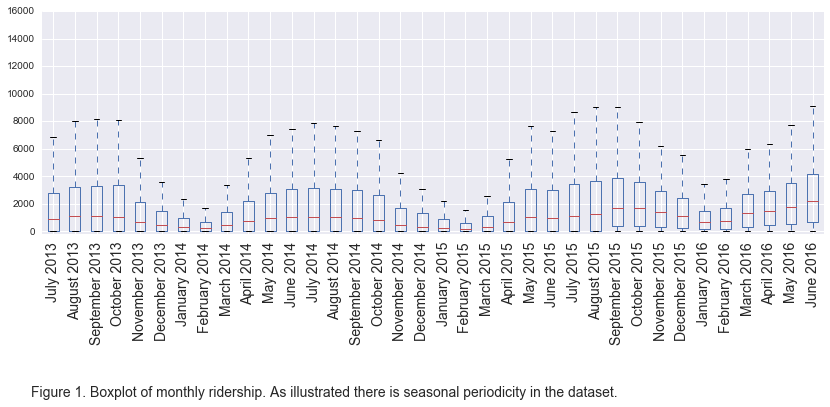

In [7]:
pl.rcParams['font.size'] = 14
f, ax = pl.subplots(figsize=(14, 4))

# create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15, 7), ax=ax, rot=90);
ax.set_ylim([-200, 16000])
ax.text(0,-12000, 'Figure 1. Boxplot of monthly ridership. As illustrated there is seasonal \
periodicity in the dataset.')

#### Seasonal Decomposition

/Users/JordanVani/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


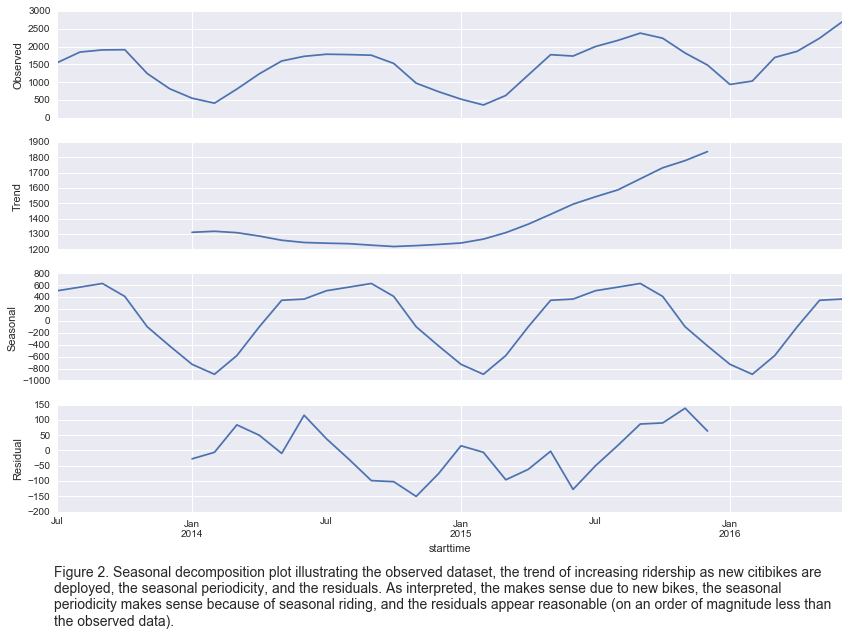

In [8]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize'] = (12, 8)
resplot = res.plot()
resplot.text(0.07, -0.1, 'Figure 2. Seasonal decomposition plot illustrating the \
observed dataset, the trend of increasing ridership as new citibikes are \n\
deployed, the seasonal periodicity, and the residuals. As interpreted, the \
makes sense due to new bikes, the seasonal \nperiodicity makes sense because of \
seasonal riding, and the residuals appear reasonable (on an order of magnitude \
less than \nthe observed data).')

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [9]:
station_id = DataFrame.from_csv('Data/Station_id.csv')

#convert station_ids to string index
station_id.index = station_id.index.astype(str)

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [10]:
# Combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)

# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))

### Intersect the two geometries

In [11]:
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r', "%", str((i + 1) * 100 / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100


### Add Monthly rides to the station GeoDataFrame with CT code

In [12]:
### Create average monthly rides column for each summer & winter.
station_id['MonthlyAve'] = df_bike_monthly.sum()

#Create df of winter months
winter = df_bike_monthly[(df_bike_monthly.index.month == 1) |
                         (df_bike_monthly.index.month == 2) |
                         (df_bike_monthly.index.month == 3) |
                         (df_bike_monthly.index.month == 10) |
                         (df_bike_monthly.index.month == 11) |
                         (df_bike_monthly.index.month == 12)]

# Create df of summer months
summer = df_bike_monthly[(df_bike_monthly.index.month == 4) |
                         (df_bike_monthly.index.month == 5) |
                         (df_bike_monthly.index.month == 6) |
                         (df_bike_monthly.index.month == 7) |
                         (df_bike_monthly.index.month == 8) |
                         (df_bike_monthly.index.month == 9)]

station_id['Winter_Avg'] = winter.sum()
station_id['Summer_Avg'] = summer.sum()

In [13]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,Winter_Avg,Summer_Avg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,26930,42378
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,35178,67646
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,104440,169085
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,37865,64084
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,67720,116324


### Add the monthly average rides to the CT shapefile 

In [14]:
temp = station_id[['MonthlyAve', 'Winter_Avg', 'Summer_Avg']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_data = ct_shape.join(temp)
ct_shape_data.fillna(0, inplace=True)
temp.head()

/Users/JordanVani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,MonthlyAve,Winter_Avg,Summer_Avg,station_id
BoroCT2010,,,,
1009000,69308,26930,42378,1000
1009900,102824,35178,67646,1001
1005700,273525,104440,169085,1002
1001800,101949,37865,64084,1003
1006100,184044,67720,116324,1004


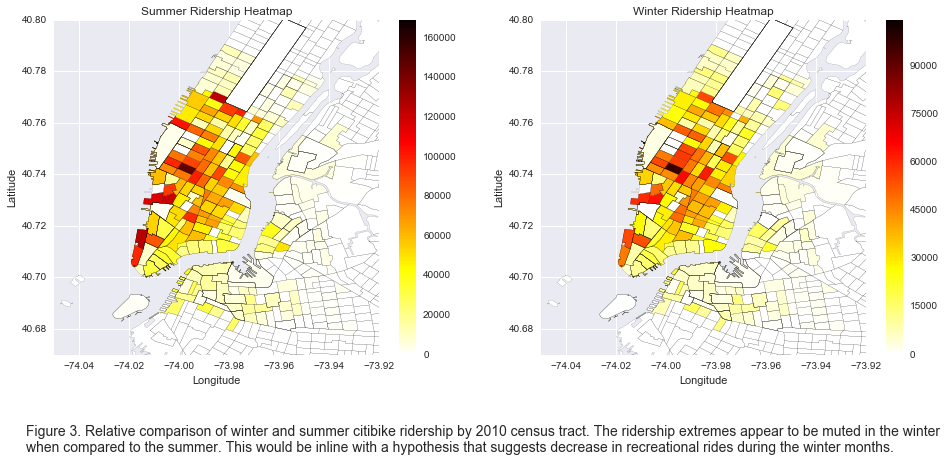

In [15]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Summer Plot
ct_shape_data.plot(column='Summer_Avg', cmap='hot_r', alpha=1,
                   linewidth=0.1, ax=ax1)
ax1.set_title('Summer Ridership Heatmap')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.axis([-74.05, -73.92, 40.67, 40.80])

normalize = mcolors.Normalize(vmin=ct_shape_data.Summer_Avg.min(),
                              vmax=ct_shape_data.Summer_Avg.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(ct_shape_data.Summer_Avg)
pl.colorbar(scalarmappaple, ax=ax1)

# Winter Plot
ct_shape_data.plot(column='Winter_Avg', cmap='hot_r', alpha=1,
                   linewidth=0.1, ax=ax2)
ax2.set_title('Winter Ridership Heatmap')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.axis([-74.05, -73.92, 40.67, 40.80])

normalize = mcolors.Normalize(vmin=ct_shape_data.Winter_Avg.min(),
                              vmax=ct_shape_data.Winter_Avg.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(ct_shape_data.Winter_Avg)
pl.colorbar(scalarmappaple, ax=ax2)

fig.text(0.1, -0.1, 'Figure 3. Relative comparison of winter and \
summer citibike ridership by 2010 census tract. The ridership \
extremes appear to be muted in the winter \nwhen compared to \
the summer. This would be inline with a hypothesis that suggests \
decrease in recreational rides during the winter months.')

### Removing the CTs that are out of zoom boundries

In [16]:
ct_shape_data_zoom = (ct_shape_data[
        ct_shape_data.centroid.apply(
            lambda c: c.x > -74.05 and c.x < -73.92 and
            c.y > 40.67 and c.y < 40.8)])

In [17]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(ct_shape_data_zoom)

Total number of CTs: 2166
Number of zoomed CTs: 723


### Map the monthly rides 

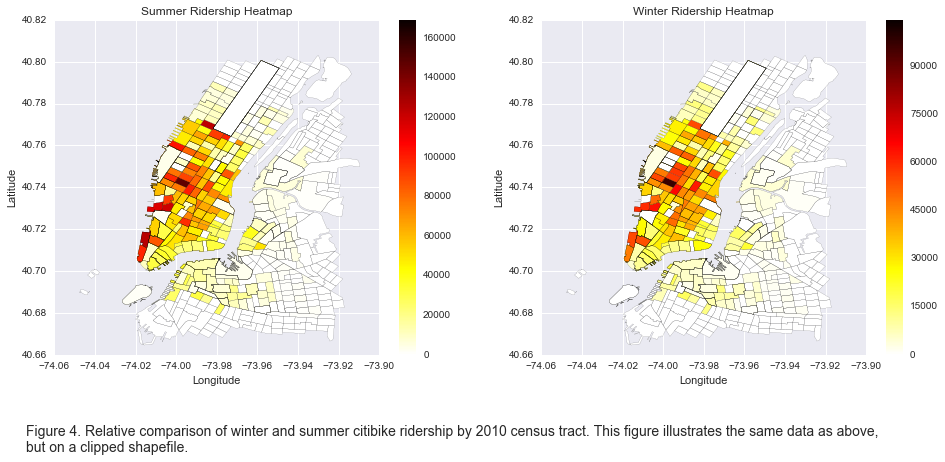

In [18]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Summer Plot
ct_shape_data_zoom.plot(column='Summer_Avg', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax1)
ax1.set_title('Summer Ridership Heatmap')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=ct_shape_data_zoom.Summer_Avg.min(),
                              vmax=ct_shape_data_zoom.Summer_Avg.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(ct_shape_data_zoom.Summer_Avg)
pl.colorbar(scalarmappaple, ax=ax1)

# Winter Plot
ct_shape_data_zoom.plot(column='Winter_Avg', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax2)
ax2.set_title('Winter Ridership Heatmap')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=ct_shape_data_zoom.Winter_Avg.min(),
                              vmax=ct_shape_data_zoom.Winter_Avg.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(ct_shape_data_zoom.Winter_Avg)
pl.colorbar(scalarmappaple, ax=ax2)

fig.text(0.1, -0.1, 'Figure 4. Relative comparison of winter and summer \
citibike ridership by 2010 census tract. This figure illustrates the \
same data as above, \nbut on a clipped shapefile.')

### Export Shapefile CTs in the CitiBike Zone

In [19]:
# IMPORTANT
path='Output/ct_shape_data_zoom.shp'
ct_shape_data_zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [20]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [21]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [22]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [23]:
Wmatrix, ids = qW_CT.full()

In [24]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [25]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [26]:
SummerRide = ct_shape_data_zoom.Summer_Avg
SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)

WinterRide = ct_shape_data_zoom.Winter_Avg
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [27]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
print SummerRideLagQ10

WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
print WinterRideLagQ10

                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=     0.000               81
    0.000 < x[i] <=  1424.004               64
 1424.004 < x[i] <=  4159.367               72
 4159.367 < x[i] <=  8480.133               72
 8480.133 < x[i] <= 12743.000               74
12743.000 < x[i] <= 25336.933               71
25336.933 < x[i] <= 43237.717               72
43237.717 < x[i] <= 53693.345               72
53693.345 < x[i] <= 62326.940               72
62326.940 < x[i] <= 94018.643               73
                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=     0.000               86
    0.000 < x[i] <=  1111.152               59
 1111.152 < x[i] <=  2784.200               72
 2784.200 < x[i] <=  5642.698               72
 5642.698 < x[i] <=  7734.214               73
 7734.214 < x[i] <= 14752.800               72
14752.800 < x[i] <= 25104.474               72
25104.474

#### Map the monthly rides lag

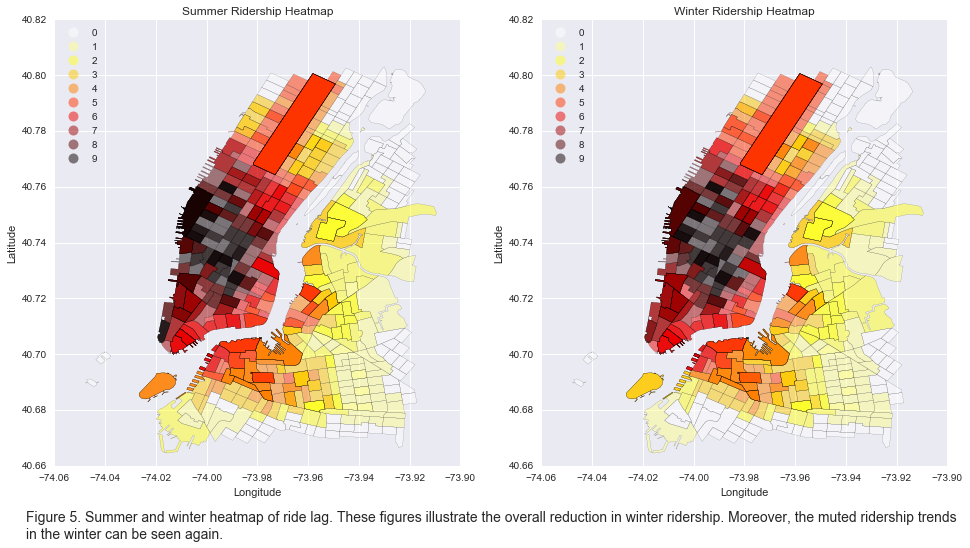

In [28]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Summer Plot
ct_shape_data_zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl',
        categorical=True, k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='k', legend=True)
ax1.set_title('Summer Ridership Heatmap')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Winter Plot
ct_shape_data_zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', 
        categorical=True, k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='k', legend=True)
ax2.set_title('Winter Ridership Heatmap')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

fig.text(0.1, -0, 'Figure 5. Summer and winter heatmap of ride lag. \
These figures illustrate the overall reduction in winter ridership. Moreover, \
the muted ridership trends \nin the winter can be seen again.')

## Global  Spatial Autocorrelation

In [29]:
b, a = np.polyfit(SummerRide, SummerRideLag, 1)
print b, a 

b1, a1 = np.polyfit(WinterRide, WinterRideLag, 1)
print b1, a1 

0.62482891224 9444.7305052
0.63990965963 5382.3849299


### Moran Scatterplot

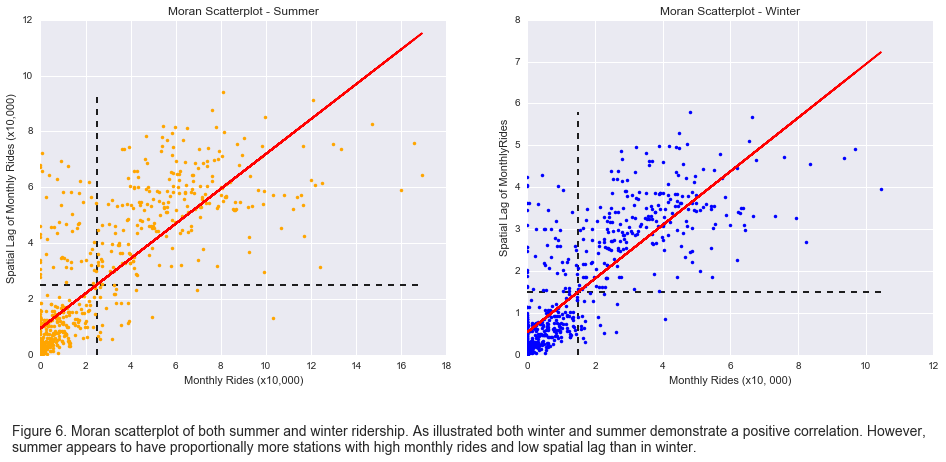

In [30]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Summer Plot
ax1.plot(SummerRide / 10000, SummerRideLag / 10000, '.', color='orange')
ax1.plot(SummerRide / 10000, (a + b * SummerRide) / 10000, 'r')
ax1.vlines(SummerRide.mean() / 10000, SummerRideLag.min() / 10000,
           SummerRideLag.max() / 10000, linestyle='--')
ax1.hlines(SummerRideLag.mean() / 10000, SummerRide.min() / 10000,
           SummerRide.max() / 10000, linestyle='--')

ax1.set_title('Moran Scatterplot - Summer')
ax1.set_xlabel('Monthly Rides (x10,000)')
ax1.set_ylabel('Spatial Lag of Monthly Rides (x10,000)')

# Winter Plot
ax2.plot(WinterRide / 10000, WinterRideLag / 10000, '.', color='b')
ax2.plot(WinterRide / 10000, (a1 + b1 * WinterRide) / 10000, 'r')
ax2.vlines(WinterRide.mean() / 10000, WinterRideLag.min() / 10000,
           WinterRideLag.max() / 10000, linestyle='--')
ax2.hlines(WinterRideLag.mean() / 10000, WinterRide.min() / 10000,
           WinterRide.max() / 10000, linestyle='--')

ax2.set_title('Moran Scatterplot - Winter')
ax2.set_xlabel('Monthly Rides (x10, 000)')
ax2.set_ylabel('Spatial Lag of MonthlyRides')

fig.text(0.1, -0.1, 'Figure 6. Moran scatterplot of both summer and winter ridership. \
As illustrated both winter and summer demonstrate a positive correlation. However, \n\
summer appears to have proportionally more stations with high monthly rides and low \
spatial lag than in winter.')

### Moran's I

In [31]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [32]:
print I_SummerRide.I, I_SummerRide.p_sim
print I_WinterRide.I, I_WinterRide.p_sim

0.624859478454 0.001
0.639930875464 0.001


Thus, the $I$ statistic is approx. $0.6$ for for both winter & summer, and each have a very small $p$ value. 

In [33]:
I_SummerRide.sim[0:10]

array([-0.03124963,  0.0083493 ,  0.0196907 ,  0.01585403,  0.02082228,
       -0.0072113 ,  0.03778571, -0.01178281, -0.05205868, -0.03609837])

In [34]:
I_WinterRide.sim[0:10]

array([ 0.00582942,  0.00207874,  0.01183855, -0.01951895,  0.00559805,
        0.00074262,  0.02633467, -0.00929356,  0.00456576, -0.01096718])

### KDEplot of all of the simulated points
the vertical line shows the observed value

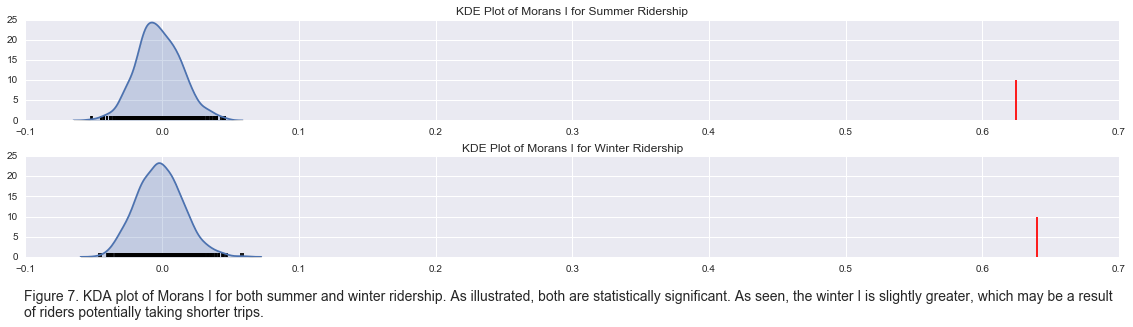

In [35]:
fig, (ax1, ax2) = pl.subplots(nrows=2, ncols=1, figsize=(16, 4))
fig.tight_layout()

# Summer Plot
sns.kdeplot(I_SummerRide.sim, shade=True, ax=ax1)
ax1.vlines(I_SummerRide.sim, 0, 1)
ax1.vlines(I_SummerRide.I, 0, 10, 'r')
ax1.set_title('KDE Plot of Morans I for Summer Ridership')

# Winter Plot
sns.kdeplot(I_WinterRide.sim, shade=True, ax=ax2)
ax2.vlines(I_WinterRide.sim, 0, 1)
ax2.vlines(I_WinterRide.I, 0, 10, 'r')
ax2.set_title('KDE Plot of Morans I for Winter Ridership')

fig.text(0.03, -0.1, 'Figure 7. KDA plot of Morans I for both summer and \
winter ridership. As illustrated, both are statistically significant. As \
seen, the winter I is slightly greater, which may be a result \nof riders \
potentially taking shorter trips.')

## Local  Spatial Autocorrelation

In [36]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [37]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.19734557,  0.00067907, -0.00108434, -0.00105966]),
 array([ 0.001,  0.235,  0.463,  0.434,  0.471]))

In [38]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [39]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.22961369,  0.01235216,  0.00086372, -0.08773271]),
 array([ 0.001,  0.213,  0.403,  0.398,  0.325]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [40]:
sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

sigs1 = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs1 = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs1 = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs1 = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

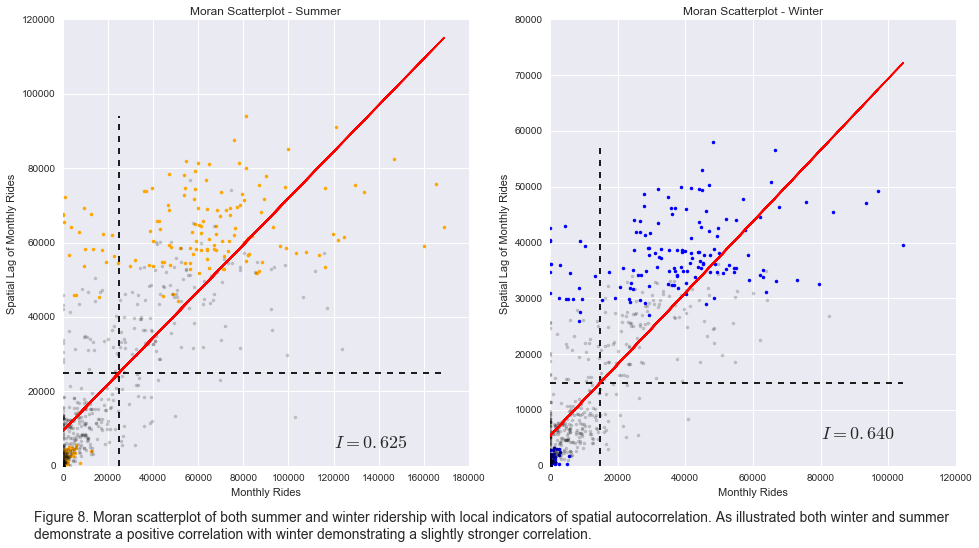

In [41]:
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Summer Plot
ax1.plot(sigs, W_sigs, '.', color='orange')
ax1.plot(insigs, W_insigs, '.k', alpha=.2)
ax1.plot(SummerRide, (a + b * SummerRide), 'r')
ax1.vlines(SummerRide.mean(), SummerRideLag.min(),
           SummerRideLag.max(), linestyle='--')
ax1.hlines(SummerRideLag.mean(), SummerRide.min(),
           SummerRide.max(), linestyle='--')

ax1.set_title('Moran Scatterplot - Summer')
ax1.set_xlabel('Monthly Rides')
ax1.set_ylabel('Spatial Lag of Monthly Rides')
ax1.text(s='$I = %.3f$' % I_SummerRide.I, x=120000, y=5000, fontsize=18)

# Winter Plot
ax2.plot(sigs1, W_sigs1, '.', color='b')
ax2.plot(insigs1, W_insigs1, '.k', alpha=.2)
ax2.plot(WinterRide, (a1 + b1 * WinterRide), 'r')
ax2.vlines(WinterRide.mean(), WinterRideLag.min(),
           WinterRideLag.max(), linestyle='--')
ax2.hlines(WinterRideLag.mean(), WinterRide.min(),
           WinterRide.max(), linestyle='--')

ax2.set_title('Moran Scatterplot - Winter')
ax2.set_xlabel('Monthly Rides')
ax2.set_ylabel('Spatial Lag of Monthly Rides')
ax2.text(s='$I = %.3f$' % I_WinterRide.I, x=80000, y=5000, fontsize=18)

fig.text(0.1, -0, 'Figure 8. Moran scatterplot of both summer and winter \
ridership with local indicators of spatial autocorrelation. As illustrated \
both winter and summer \ndemonstrate a positive correlation with winter \
demonstrating a slightly stronger correlation.')

### Hot and Cold spots 

In [42]:
# Summer
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig

# Winter
sig1 = LMo_WinterRide.p_sim < 0.01
hotspots1 = LMo_WinterRide.q==1 * sig1
coldspots1 = LMo_WinterRide.q==3 * sig1

print "Number of Hotspots in Summer:", hotspots.sum()
print "Number of Coldspots in Summer:", coldspots.sum()
print "Number of Hotspots in Winter:", hotspots1.sum()
print "Number of Coldspots in Winter:", coldspots1.sum()

Number of Hotspots in Summer: 181
Number of Coldspots in Summer: 229
Number of Hotspots in Winter: 180
Number of Coldspots in Winter: 222


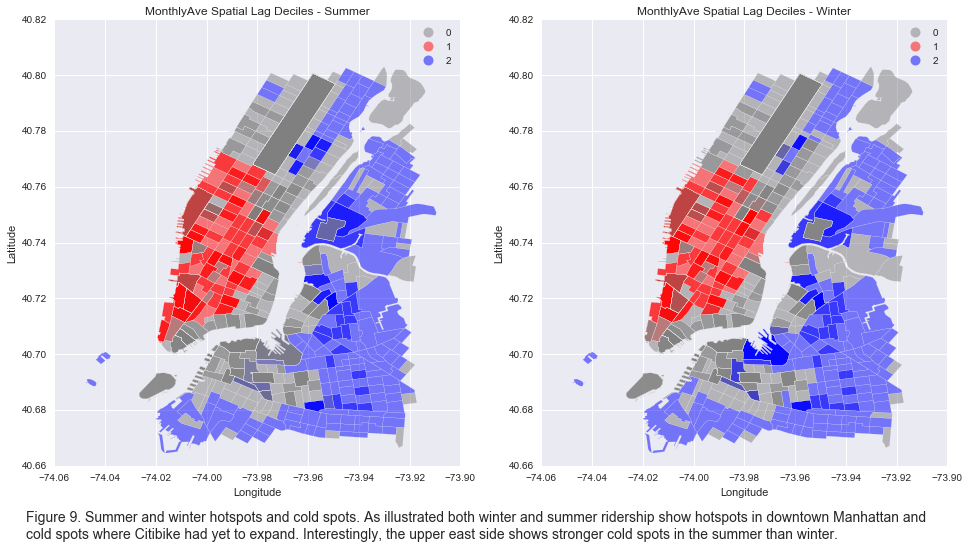

In [43]:
hcmap = mcolors.ListedColormap(['grey','red','blue'])
hotcold = hotspots * 1 + coldspots * 2
hotcold1 = hotspots1 * 1 + coldspots1 * 2

#New Plot
fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Summer Plot
ct_shape_data_zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_title('MonthlyAve Spatial Lag Deciles - Summer')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Winter Plot
ct_shape_data_zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_title('MonthlyAve Spatial Lag Deciles - Winter')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

fig.text(0.1, -0, 'Figure 9. Summer and winter hotspots and cold spots. \
As illustrated both winter and summer ridership show hotspots in downtown \
Manhattan and \ncold spots where Citibike had yet to expand. Interestingly, \
the upper east side shows stronger cold spots in the summer than winter.')